# Dataset slicing
An event recording is somewhat similar to a video. Sometimes it is desirable to slice a single event recording into multiple samples. During training time, we might want to load just a slice of a recording rather than the whole one. This is typically the case when training an ANN on event frames or if one recording contains multiple labels. We specify a `slicer` method which decides how recordings are cut into smaller chunks. Let's look at how we can cut a sample of the DVS gesture dataset into smaller pieces.

In [1]:
import tonic
from tonic import SlicedDataset
from tonic.slicers import SliceByTime

dataset = tonic.datasets.DVSGesture(save_to='./data', train=False)

slicing_time_window = 250000
slicer = SliceByTime(time_window=slicing_time_window)
sliced_dataset = SlicedDataset(dataset, slicer=slicer, metadata_path='./metadata/dvs_gesture')

  0%|          | 0/691455012 [00:00<?, ?it/s]

Extracting ./data/DVSGesture/ibmGestureTest.tar.gz to ./data/DVSGesture
Metadata written to disk.


In [2]:
print(f"Went from {len(dataset)} samples in the original dataset to {len(sliced_dataset)} in the sliced version.")

Went from 264 samples in the original dataset to 7041 in the sliced version.


In [3]:
events, targets = sliced_dataset[100]

We can verify that the difference between last and first timestamp in the slice is not greater than our slicing time window earlier

In [4]:
slice_time_difference = events["t"][-1] - events["t"][0]
print(f"Difference between last and first timestamp in slice: {slice_time_difference} us")
assert slice_time_difference <= slicing_time_window

Difference between last and first timestamp in slice: 249878 us


## Applying transforms post-slicing
As normally, we can specify transform and/or target_transform which will be applied to the slice after loading.

In [5]:
sensor_size = tonic.datasets.DVSGesture.sensor_size
frame_transform = tonic.transforms.ToFrame(sensor_size=sensor_size, 
                                           time_window=50000, 
                                           include_incomplete=True)

sliced_dataset = SlicedDataset(dataset, slicer=slicer, transform=frame_transform, metadata_path='./metadata/dvs_gesture')

Read metadata from disk.


In [6]:
frames, targets = sliced_dataset[100]

We can verify that the sum of events in the frames is the same as the number of events without transform.

In [7]:
print("Number of spikes: " + str(frames.sum()))
assert frames.sum() == len(events)

Number of spikes: 16068


## Caching a SlicedDataset
Additionally, we can wrap our newly sliced dataset in a CachedDataset, which will write the slices to disk. We'll also provide an augmentation transform that is applied post-loading from cache.

In [8]:
import torch
import torchvision
from tonic import CachedDataset
torch.manual_seed(1234)

augmentation = tonic.transforms.Compose([torch.tensor,
                                         torchvision.transforms.RandomRotation([-90,90])])
augmented_dataset = CachedDataset(sliced_dataset, cache_path='./cache/slicing', transform=augmentation)

In [9]:
rotated_frames, targets = augmented_dataset[100]

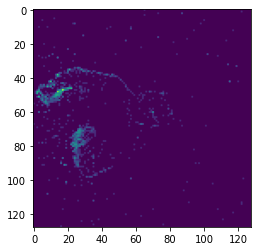

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(rotated_frames[0,0])